In [ ]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
!git branch -a

  main
* test
  remotes/origin/HEAD -> origin/main
  remotes/origin/binary-tree
  remotes/origin/main
  remotes/origin/test


# 1. Aquisição dos Dados

In [ ]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)
  
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# 2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [ ]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


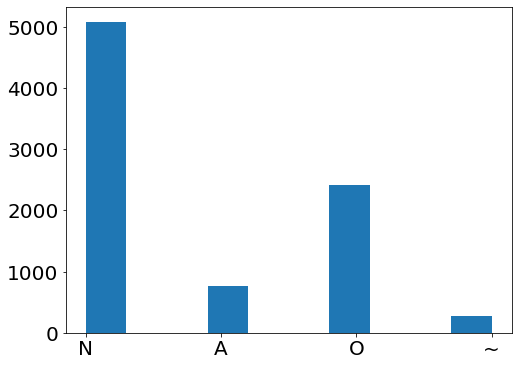

In [ ]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

### 2.2 Wavelet helping functions

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

### 2.3 Aplicação da tranformada Wavelet

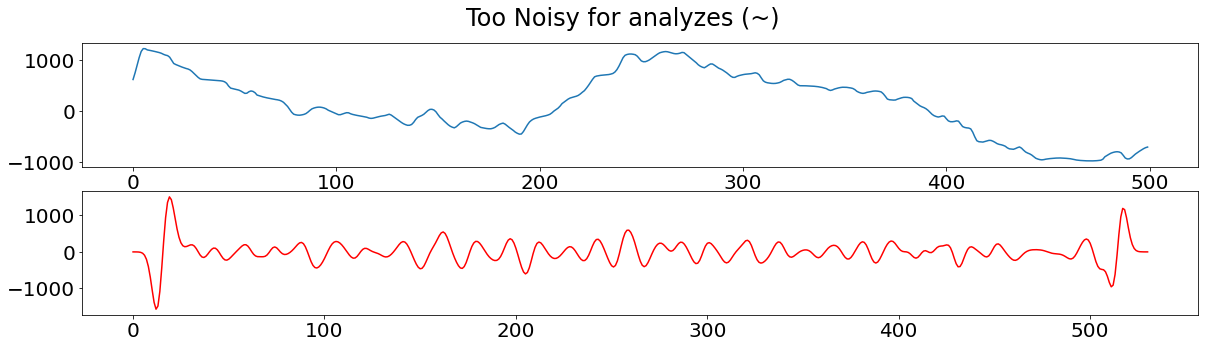

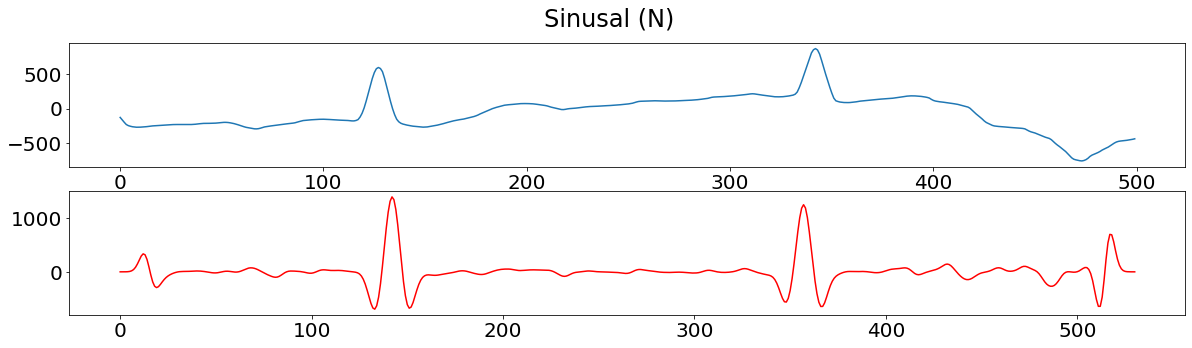

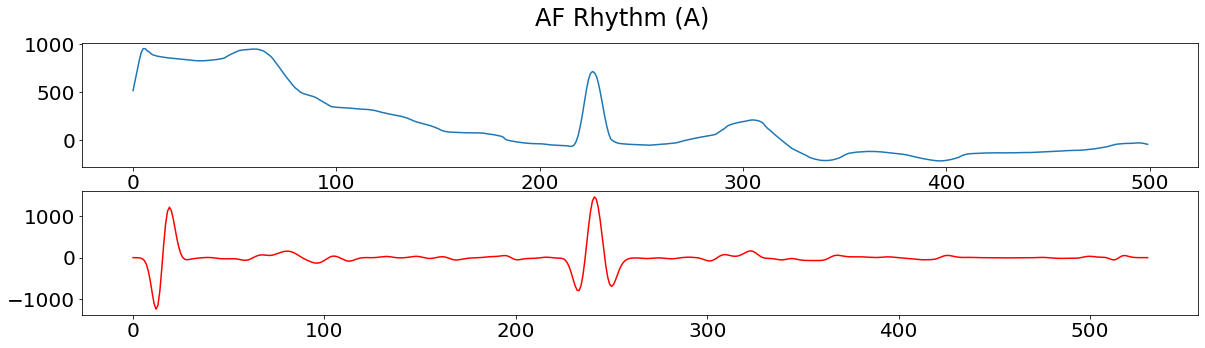

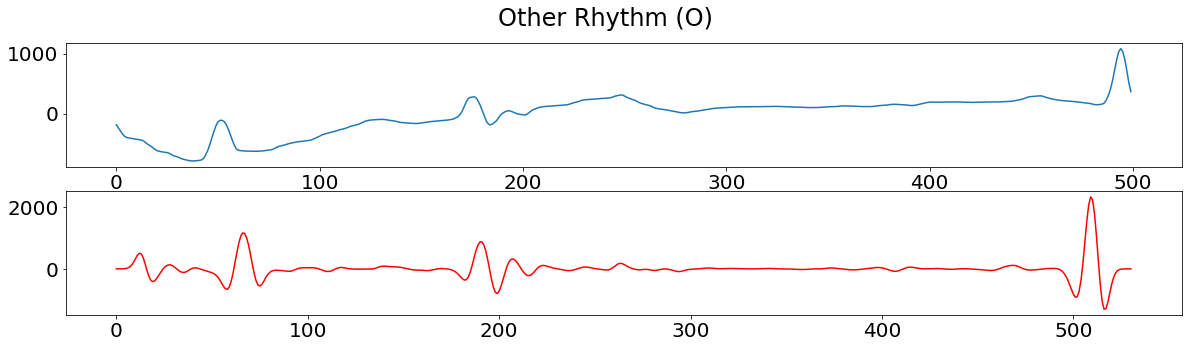

In [ ]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()


In [ ]:
x = []
for i in signals:
  val = apply_wavelet(i, 3)
  x.append(val)

### 2.4 Janelamento dos dados de treino

In [ ]:
intersection = 100
window_size = 500
windows_array = ["max","max","max","max"]
classes_array = ['N', 'O', 'A', '~']

In [ ]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection)
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [ ]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:

    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [ ]:
x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux_train, classes_array, windows_array, intersection, window_size)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux_valid, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")
  

N
Média: 500.0
Std: 0.0
Qntd: 80791
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 40946
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 11758
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3550
Min: 500
---------------


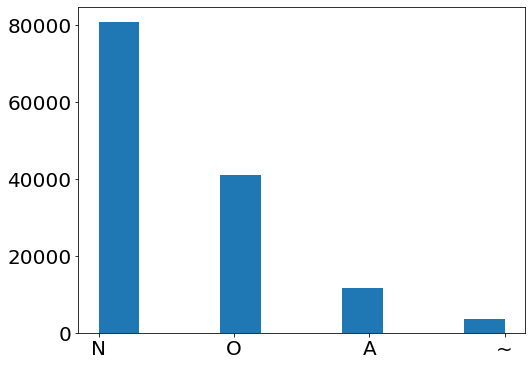

In [ ]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

In [ ]:
d_train = d_train.sample(frac=1, random_state=1)
signals_2 = d_train["signals"]
classes_2 = d_train["classes"]

### 2.4 "Normalização" do tamanho dos sinais

In [ ]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]
# 3. Implementação da CNN

# 3. Implementação do modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
y_train = classes_2
y_valid = d_valid["classes"]

x_train = list(signals_2)
x_valid = list(d_valid["signals"])

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

<ipython-input-17-9e0a7ed50a84>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(x_test)


In [ ]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, classification_report

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
def create_cnn(x_train, y_train, x_valid, y_valid):
  
  #x_train = np.array(list(x_train))
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

  y_train = pd.get_dummies(y_train)
  y_valid = pd.get_dummies(y_valid)


  print(y_train.columns)

  input_shape = len(x_train[0])
  k1 = 5
  k2 = 3
  n = math.floor(input_shape/(k1+k2-2))
  nn_input = input_shape % (k1+k2-2)

  classificador = Sequential()

  for i  in range(0, 5):
    if i == 0:
      classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    else:
        classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
    
    classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))

  classificador.add(Flatten())

  classificador.add(Dense(units=64, activation='relu'))
  classificador.add(Dense(units=32, activation='relu'))
  classificador.add(Dense(units=16, activation='relu'))

  classificador.add(Dense(2, activation="softmax"))

  checkpoint = ModelCheckpoint('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
  es = EarlyStopping(monitor="accuracy", mode='max', verbose=0, patience=15)

  classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])

  history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100,
                              batch_size=128, callbacks=checkpoint, verbose=1, shuffle=True)


  
  return y_train.columns, classificador, history

# 4. Implementação da árvore

In [ ]:
# x_train = x_train[0:200]
# y_train = y_train[0:200]

In [ ]:
class RootNode:
  def __init__(self):
    self.child = None

In [ ]:
class BinaryTreeNode:
  def __init__(self, model, classe):
    self.columns = None
    self.classe = classe
    self.model = model
    self.leftChild = None
    self.rightChild=None

In [ ]:
def print_history(history, classe):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy  '+classe)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    # plt.savefig("neuron3.png")
    plt.show()

In [ ]:
def build_tree(x_train, y_train, classes_array):  
  
  for i in ['A','N','O', '~']:
    nan_v = []
    for j in classes_array:
      if j != i:
        nan_v.append(j)

    
    chosen = i

    y_next = y_train.replace(nan_v, "nan")
    y_vnext = y_valid.replace(nan_v, "nan")
    columns, model, history = create_cnn(x_train, y_next, x_valid, y_vnext)
    print_history(history, chosen)
    
    y_pred = model.predict(x_valid)
    # y_pred = (np.asarray(y_pred)).round()
    # y_pred = y_pred.astype(int)

    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = columns
    y_pred = y_pred.idxmax(axis=1)

    print(y_pred)
    print(y_vnext)

    relatorio = classification_report(y_vnext, y_pred)   
    print(relatorio)


Index(['A', 'nan'], dtype='object')
Epoch 1/100
1071/1071 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.9142
Epoch 1: val_accuracy improved from -inf to 0.92304, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 29s 18ms/step - loss: 0.2570 - accuracy: 0.9142 - val_loss: 0.2313 - val_accuracy: 0.9230
Epoch 2/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9188
Epoch 2: val_accuracy improved from 0.92304 to 0.92473, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 16s 15ms/step - loss: 0.2133 - accuracy: 0.9188 - val_loss: 0.1978 - val_accuracy: 0.9247
Epoch 3/100
1071/1071 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9209
Epoch 3: val_accuracy improved from 0.92473 to 0.92829, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.2048 - accuracy: 0.9209 - val_loss: 0.1960 - val_accuracy: 0.9283
Epoch 4/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.1999 - accuracy: 0.9225
Epoch 4: val_accuracy did not improve from 0.92829
1071/1071 [==============================] - 14s 13ms/step - loss: 0.1998 - accuracy: 0.9225 - val_loss: 0.1916 - val_accuracy: 0.9283
Epoch 5/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9247
Epoch 5: val_accuracy did not improve from 0.92829
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1925 - accuracy: 0.9247 - val_loss: 0.1909 - val_accuracy: 0.9275
Epoch 6/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9269
Epoch 6: val_accuracy improved from 0.92829 to 0.92894, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.1879 - accuracy: 0.9269 - val_loss: 0.1920 - val_accuracy: 0.9289
Epoch 7/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9290
Epoch 7: val_accuracy improved from 0.92894 to 0.92953, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.1831 - accuracy: 0.9290 - val_loss: 0.1971 - val_accuracy: 0.9295
Epoch 8/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9304
Epoch 8: val_accuracy improved from 0.92953 to 0.93355, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.1802 - accuracy: 0.9305 - val_loss: 0.1936 - val_accuracy: 0.9335
Epoch 9/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9318
Epoch 9: val_accuracy did not improve from 0.93355
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1771 - accuracy: 0.9318 - val_loss: 0.1882 - val_accuracy: 0.9326
Epoch 10/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9337
Epoch 10: val_accuracy did not improve from 0.93355
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1715 - accuracy: 0.9337 - val_loss: 0.1820 - val_accuracy: 0.9334
Epoch 11/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9350
Epoch 11: val_accuracy improved from 0.93355 to 0.93387, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.1692 - accuracy: 0.9350 - val_loss: 0.1812 - val_accuracy: 0.9339
Epoch 12/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9368
Epoch 12: val_accuracy did not improve from 0.93387
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1645 - accuracy: 0.9368 - val_loss: 0.2000 - val_accuracy: 0.9306
Epoch 13/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9374
Epoch 13: val_accuracy improved from 0.93387 to 0.93419, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.1635 - accuracy: 0.9375 - val_loss: 0.1828 - val_accuracy: 0.9342
Epoch 14/100
1071/1071 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9382
Epoch 14: val_accuracy did not improve from 0.93419
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1598 - accuracy: 0.9382 - val_loss: 0.1888 - val_accuracy: 0.9285
Epoch 15/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9395
Epoch 15: val_accuracy did not improve from 0.93419
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1574 - accuracy: 0.9395 - val_loss: 0.1875 - val_accuracy: 0.9304
Epoch 16/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9410
Epoch 16: val_accuracy did not improve from 0.93419
1071/1071 [==============================] - 15s 14ms/step - loss: 0.1541 - accuracy: 0.9410 - val_loss: 0.1878 - val_accuracy: 0.9342
Epoc

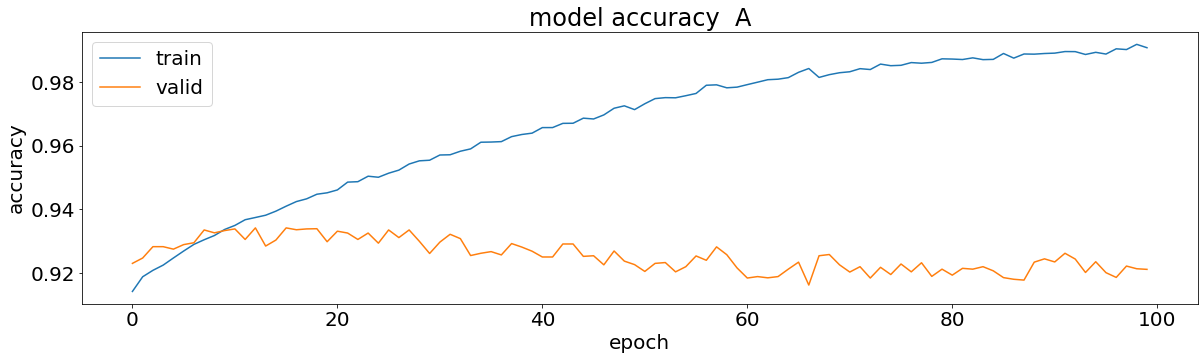

482/482 [==============================] - 2s 3ms/step
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419    nan
15420    nan
15421    nan
15422    nan
15423    nan
Length: 15424, dtype: object
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419    nan
15420    nan
15421    nan
15422    nan
15423    nan
Name: classes, Length: 15424, dtype: object
              precision    recall  f1-score   support

           A       0.52      0.49      0.51      1267
         nan       0.95      0.96      0.96     14157

    accuracy                           0.92     15424
   macro avg       0.74      0.73      0.73     15424
weighted avg       0.92      0.92      0.92     15424

Index(['N', 'nan'], dtype='object')
Epoch 1/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.6177 - accuracy: 0.6846
Epoch 1: val_accuracy improved from -inf to 0.67577, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 16ms/step - loss: 0.6177 - accuracy: 0.6845 - val_loss: 0.6154 - val_accuracy: 0.6758
Epoch 2/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.5610 - accuracy: 0.7211
Epoch 2: val_accuracy improved from 0.67577 to 0.70831, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5609 - accuracy: 0.7212 - val_loss: 0.5787 - val_accuracy: 0.7083
Epoch 3/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7350
Epoch 3: val_accuracy improved from 0.70831 to 0.71240, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5431 - accuracy: 0.7350 - val_loss: 0.5677 - val_accuracy: 0.7124
Epoch 4/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.5343 - accuracy: 0.7418
Epoch 4: val_accuracy improved from 0.71240 to 0.71298, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5344 - accuracy: 0.7416 - val_loss: 0.5650 - val_accuracy: 0.7130
Epoch 5/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.5260 - accuracy: 0.7468
Epoch 5: val_accuracy improved from 0.71298 to 0.71745, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5260 - accuracy: 0.7467 - val_loss: 0.5588 - val_accuracy: 0.7175
Epoch 6/100
1071/1071 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7507
Epoch 6: val_accuracy improved from 0.71745 to 0.72374, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5192 - accuracy: 0.7507 - val_loss: 0.5605 - val_accuracy: 0.7237
Epoch 7/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.7542
Epoch 7: val_accuracy did not improve from 0.72374
1071/1071 [==============================] - 15s 14ms/step - loss: 0.5152 - accuracy: 0.7541 - val_loss: 0.5531 - val_accuracy: 0.7224
Epoch 8/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.5091 - accuracy: 0.7589
Epoch 8: val_accuracy did not improve from 0.72374
1071/1071 [==============================] - 15s 14ms/step - loss: 0.5091 - accuracy: 0.7589 - val_loss: 0.5669 - val_accuracy: 0.7216
Epoch 9/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7636
Epoch 9: val_accuracy improved from 0.72374 to 0.72718, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5028 - accuracy: 0.7636 - val_loss: 0.5667 - val_accuracy: 0.7272
Epoch 10/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.4996 - accuracy: 0.7644
Epoch 10: val_accuracy did not improve from 0.72718
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4995 - accuracy: 0.7644 - val_loss: 0.5657 - val_accuracy: 0.7250
Epoch 11/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.4940 - accuracy: 0.7677
Epoch 11: val_accuracy improved from 0.72718 to 0.73275, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.4940 - accuracy: 0.7676 - val_loss: 0.5499 - val_accuracy: 0.7328
Epoch 12/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.7700
Epoch 12: val_accuracy did not improve from 0.73275
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4895 - accuracy: 0.7700 - val_loss: 0.5462 - val_accuracy: 0.7321
Epoch 13/100
1071/1071 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.7736
Epoch 13: val_accuracy did not improve from 0.73275
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4856 - accuracy: 0.7736 - val_loss: 0.5480 - val_accuracy: 0.7313
Epoch 14/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.4823 - accuracy: 0.7746
Epoch 14: val_accuracy did not improve from 0.73275
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4822 - accuracy: 0.7746 - val_loss: 0.5595 - val_accuracy: 0.7312
Epoc

1071/1071 [==============================] - 18s 17ms/step - loss: 0.4731 - accuracy: 0.7809 - val_loss: 0.5426 - val_accuracy: 0.7370
Epoch 17/100
1071/1071 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.7829
Epoch 17: val_accuracy did not improve from 0.73703
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4693 - accuracy: 0.7829 - val_loss: 0.5399 - val_accuracy: 0.7364
Epoch 18/100
1071/1071 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.7851
Epoch 18: val_accuracy did not improve from 0.73703
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4669 - accuracy: 0.7851 - val_loss: 0.5613 - val_accuracy: 0.7310
Epoch 19/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.4629 - accuracy: 0.7868
Epoch 19: val_accuracy did not improve from 0.73703
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4629 - accuracy: 0.7868 - val_loss: 0.5551 - val_accuracy: 0.7361
Epoc

1071/1071 [==============================] - 17s 16ms/step - loss: 0.4436 - accuracy: 0.7971 - val_loss: 0.5513 - val_accuracy: 0.7381
Epoch 25/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.7986
Epoch 25: val_accuracy did not improve from 0.73807
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4397 - accuracy: 0.7987 - val_loss: 0.5833 - val_accuracy: 0.7287
Epoch 26/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.8028
Epoch 26: val_accuracy did not improve from 0.73807
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4336 - accuracy: 0.8028 - val_loss: 0.5650 - val_accuracy: 0.7297
Epoch 27/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8046
Epoch 27: val_accuracy did not improve from 0.73807
1071/1071 [==============================] - 15s 14ms/step - loss: 0.4311 - accuracy: 0.8046 - val_loss: 0.5592 - val_accuracy: 0.7363
Epoc

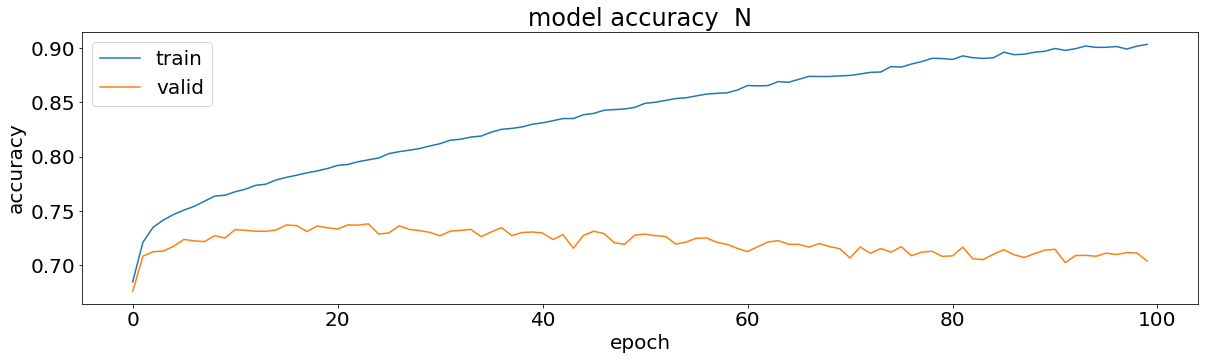

482/482 [==============================] - 2s 3ms/step
0          N
1          N
2          N
3          N
4          N
        ... 
15419      N
15420      N
15421    nan
15422      N
15423    nan
Length: 15424, dtype: object
0          N
1          N
2          N
3          N
4          N
        ... 
15419    nan
15420    nan
15421    nan
15422    nan
15423    nan
Name: classes, Length: 15424, dtype: object
              precision    recall  f1-score   support

           N       0.72      0.80      0.76      9013
         nan       0.67      0.57      0.61      6411

    accuracy                           0.70     15424
   macro avg       0.70      0.68      0.69     15424
weighted avg       0.70      0.70      0.70     15424

Index(['O', 'nan'], dtype='object')
Epoch 1/100
1071/1071 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.7019
Epoch 1: val_accuracy improved from -inf to 0.69612, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 19s 16ms/step - loss: 0.6102 - accuracy: 0.7019 - val_loss: 0.6010 - val_accuracy: 0.6961
Epoch 2/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.5790 - accuracy: 0.7135
Epoch 2: val_accuracy improved from 0.69612 to 0.71551, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5790 - accuracy: 0.7137 - val_loss: 0.5823 - val_accuracy: 0.7155
Epoch 3/100
1071/1071 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7291
Epoch 3: val_accuracy improved from 0.71551 to 0.71765, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5626 - accuracy: 0.7291 - val_loss: 0.5816 - val_accuracy: 0.7176
Epoch 4/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.5527 - accuracy: 0.7382
Epoch 4: val_accuracy improved from 0.71765 to 0.73347, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5527 - accuracy: 0.7382 - val_loss: 0.5617 - val_accuracy: 0.7335
Epoch 5/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.5449 - accuracy: 0.7433
Epoch 5: val_accuracy improved from 0.73347 to 0.73450, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 17ms/step - loss: 0.5449 - accuracy: 0.7433 - val_loss: 0.5666 - val_accuracy: 0.7345
Epoch 6/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.5377 - accuracy: 0.7482
Epoch 6: val_accuracy improved from 0.73450 to 0.74293, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.5377 - accuracy: 0.7483 - val_loss: 0.5532 - val_accuracy: 0.7429
Epoch 7/100
1071/1071 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.7524
Epoch 7: val_accuracy improved from 0.74293 to 0.74468, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 16ms/step - loss: 0.5315 - accuracy: 0.7524 - val_loss: 0.5586 - val_accuracy: 0.7447
Epoch 8/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.5261 - accuracy: 0.7564
Epoch 8: val_accuracy did not improve from 0.74468
1071/1071 [==============================] - 15s 14ms/step - loss: 0.5261 - accuracy: 0.7564 - val_loss: 0.5565 - val_accuracy: 0.7414
Epoch 9/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7578
Epoch 9: val_accuracy did not improve from 0.74468
1071/1071 [==============================] - 15s 14ms/step - loss: 0.5220 - accuracy: 0.7578 - val_loss: 0.5585 - val_accuracy: 0.7390
Epoch 10/100
1071/1071 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7622
Epoch 10: val_accuracy did not improve from 0.74468
1071/1071 [==============================] - 15s 14ms/step - loss: 0.5168 - accuracy: 0.7622 - val_loss: 0.5540 - val_accuracy: 0.7407
Epoch 11

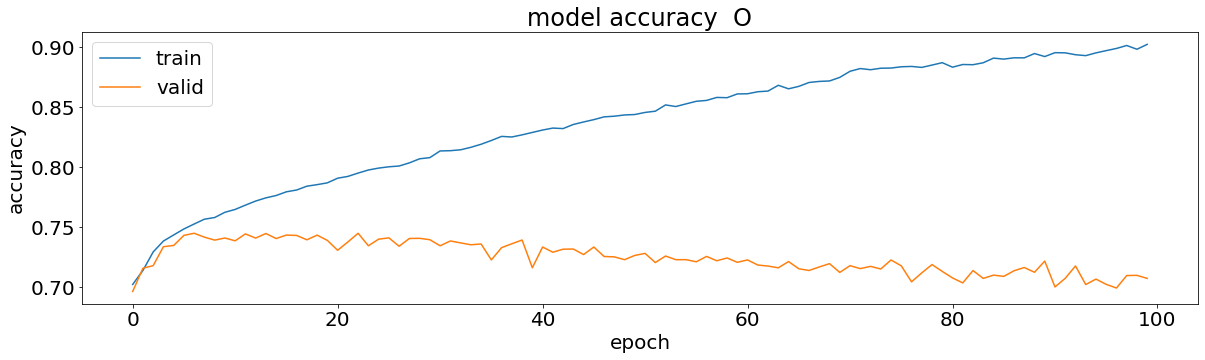

482/482 [==============================] - 2s 3ms/step
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419    nan
15420    nan
15421    nan
15422    nan
15423    nan
Length: 15424, dtype: object
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419    nan
15420    nan
15421    nan
15422    nan
15423    nan
Name: classes, Length: 15424, dtype: object
              precision    recall  f1-score   support

           O       0.53      0.40      0.45      4748
         nan       0.76      0.85      0.80     10676

    accuracy                           0.71     15424
   macro avg       0.65      0.62      0.63     15424
weighted avg       0.69      0.71      0.69     15424

Index(['nan', '~'], dtype='object')
Epoch 1/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.1370 - accuracy: 0.9747
Epoch 1: val_accuracy improved from -inf to 0.97407, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 16ms/step - loss: 0.1370 - accuracy: 0.9747 - val_loss: 0.0884 - val_accuracy: 0.9741
Epoch 2/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9750
Epoch 2: val_accuracy did not improve from 0.97407
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0877 - accuracy: 0.9750 - val_loss: 0.0826 - val_accuracy: 0.9734
Epoch 3/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9747
Epoch 3: val_accuracy improved from 0.97407 to 0.97433, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 16ms/step - loss: 0.0867 - accuracy: 0.9747 - val_loss: 0.0879 - val_accuracy: 0.9743
Epoch 4/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9751
Epoch 4: val_accuracy improved from 0.97433 to 0.97439, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 17s 16ms/step - loss: 0.0851 - accuracy: 0.9751 - val_loss: 0.0823 - val_accuracy: 0.9744
Epoch 5/100
1067/1071 [============================>.] - ETA: 0s - loss: 0.0837 - accuracy: 0.9750
Epoch 5: val_accuracy did not improve from 0.97439
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0837 - accuracy: 0.9750 - val_loss: 0.0819 - val_accuracy: 0.9739
Epoch 6/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9752
Epoch 6: val_accuracy did not improve from 0.97439
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0835 - accuracy: 0.9752 - val_loss: 0.0791 - val_accuracy: 0.9737
Epoch 7/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9752
Epoch 7: val_accuracy improved from 0.97439 to 0.97465, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 16ms/step - loss: 0.0823 - accuracy: 0.9752 - val_loss: 0.0796 - val_accuracy: 0.9746
Epoch 8/100
1071/1071 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9751
Epoch 8: val_accuracy did not improve from 0.97465
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0820 - accuracy: 0.9751 - val_loss: 0.0813 - val_accuracy: 0.9733
Epoch 9/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9754
Epoch 9: val_accuracy did not improve from 0.97465
1071/1071 [==============================] - 16s 15ms/step - loss: 0.0811 - accuracy: 0.9754 - val_loss: 0.0777 - val_accuracy: 0.9745
Epoch 10/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9755
Epoch 10: val_accuracy did not improve from 0.97465
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0802 - accuracy: 0.9755 - val_loss: 0.0799 - val_accuracy: 0.9745
Epoch 11

1071/1071 [==============================] - 17s 16ms/step - loss: 0.0793 - accuracy: 0.9754 - val_loss: 0.0776 - val_accuracy: 0.9747
Epoch 13/100
1069/1071 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9757
Epoch 13: val_accuracy improved from 0.97471 to 0.97497, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 17ms/step - loss: 0.0785 - accuracy: 0.9757 - val_loss: 0.0805 - val_accuracy: 0.9750
Epoch 14/100
1071/1071 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9759
Epoch 14: val_accuracy improved from 0.97497 to 0.97562, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/saves


1071/1071 [==============================] - 18s 17ms/step - loss: 0.0785 - accuracy: 0.9759 - val_loss: 0.0759 - val_accuracy: 0.9756
Epoch 15/100
1068/1071 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9759
Epoch 15: val_accuracy did not improve from 0.97562
1071/1071 [==============================] - 16s 15ms/step - loss: 0.0779 - accuracy: 0.9759 - val_loss: 0.0799 - val_accuracy: 0.9748
Epoch 16/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.9757
Epoch 16: val_accuracy did not improve from 0.97562
1071/1071 [==============================] - 16s 15ms/step - loss: 0.0816 - accuracy: 0.9758 - val_loss: 0.0781 - val_accuracy: 0.9751
Epoch 17/100
1070/1071 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9761
Epoch 17: val_accuracy did not improve from 0.97562
1071/1071 [==============================] - 15s 14ms/step - loss: 0.0750 - accuracy: 0.9761 - val_loss: 0.0784 - val_accuracy: 0.9742
Epoc

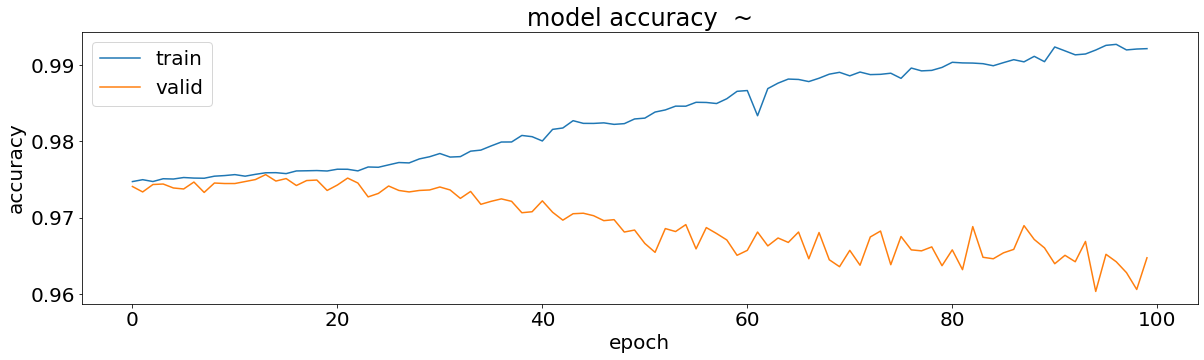

482/482 [==============================] - 2s 3ms/step
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419    nan
15420    nan
15421    nan
15422      ~
15423    nan
Length: 15424, dtype: object
0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
15419      ~
15420      ~
15421      ~
15422      ~
15423      ~
Name: classes, Length: 15424, dtype: object
              precision    recall  f1-score   support

         nan       0.98      0.99      0.98     15028
           ~       0.23      0.15      0.18       396

    accuracy                           0.96     15424
   macro avg       0.60      0.57      0.58     15424
weighted avg       0.96      0.96      0.96     15424



In [ ]:
classes_array = []
[classes_array.append(item) for item in y_train if item not in classes_array]
root = RootNode()
build_tree(x_train, y_train, classes_array)

In [ ]:
def make_prediction(current_node, samples):
    if type(current_node) == RootNode:
        current_node = current_node.child

    samples = window(signal, intersection, window_size, "max")
    samples = np.array(samples)
    samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

    while current_node.model != None:
        model = current_node.model
        prediction = model.predict(samples)
        prediction = pd.DataFrame(prediction)
        prediction.columns = current_node.columns
        prediction = prediction.idxmax(axis=1)
        prediction = prediction.mode()[0]
        # print(prediction)

        if prediction == current_node.leftChild.classe:
            current_node = current_node.leftChild
        elif prediction == current_node.rightChild.classe:
            current_node = current_node.rightChild

    return current_node.classe

In [ ]:
y_pred = []
for signal in x_test:
    prediction = make_prediction(root, signal)
    y_pred.append(prediction)

In [ ]:
classes_list = []
for i in y_test:
    if i not in classes_list:
        classes_list.append(i)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes_list)
cm_display.plot()
plt.savefig("test.png")

In [ ]:
acc = accuracy_score(y_test, y_pred)

print("matriz de confusão:", cf_matrix)
print("labels:", classes_list)
print("acurácia:", acc)